# Rock, Paper, Scissors

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from pathlib import Path
from lib.image_transforms import stateless_random_rotate

In [2]:
builder = tfds.builder(
    'rock_paper_scissors',
    data_dir = "./data")

builder.download_and_prepare()

train, test = builder.as_dataset(
    split = ['train', 'test'],
    shuffle_files = True)

In [3]:
label_encoder = builder.info.features['label']

## Classifying CG Hands

The dataset provided uses a images of hands that were generated using computer graphics software. Most of the hand poses are slight variations in angles of a base CG hand and can potentially introduce some biases into the convolution model that we will be using.

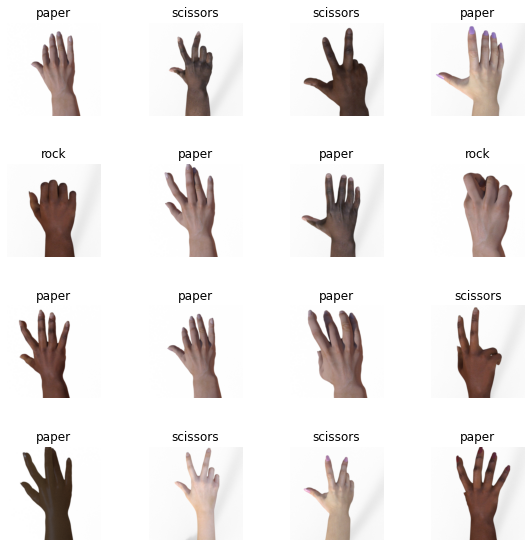

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
fig.tight_layout()

for ax, data in zip(axes.ravel(), train.take(16)):
    ax.imshow(data['image'].numpy())
    ax.set_title("{}".format(label_encoder.int2str(data['label'])))
    ax.axis("off")

In [5]:
seed = 23916481831
rng = tf.random.Generator.from_seed(seed)

In [6]:
IMG_SIZE = (256, 256)
DELTA_BRIGHTNESS = 0.1

def standardize_img(data):
    image, label = data['image'], data['label']
    image = tf.image.resize(image, IMG_SIZE) / 255.
    label = tf.one_hot(label, depth = 3)
    
    return image, label

def augmentation(image, label):
    rng_seed = rng.make_seeds(1)[:, 0]
    
    image = tf.image.stateless_random_brightness(image, DELTA_BRIGHTNESS, seed = rng_seed)
    image = tf.image.stateless_random_flip_left_right(image, seed = rng_seed)
    image = tf.image.stateless_random_flip_up_down(image, seed = rng_seed)
    image = stateless_random_rotate(image, 30, seed = rng_seed, fill_value=1.)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [7]:
BATCH_SIZE = 64

trainloader = (
    train
    .shuffle(1000)
    .map(standardize_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

testloader = (
    test
    .map(standardize_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

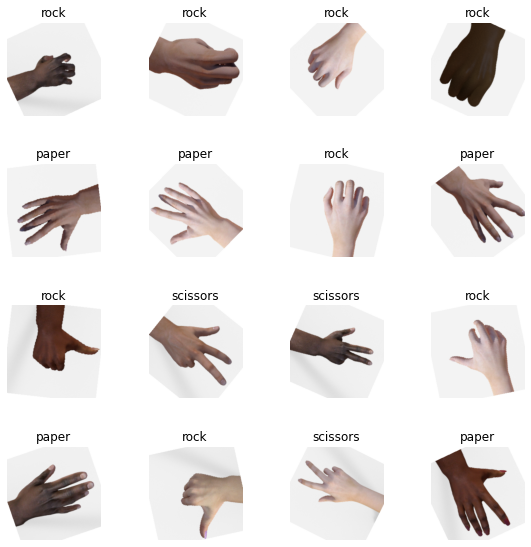

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
fig.tight_layout()

for img, label in trainloader.take(1):
    label = tf.argmax(label, axis = 1)
    for ax, i in zip(axes.ravel(), range(16)):
        ax.imshow(img[i].numpy())
        ax.set_title("{}".format(label_encoder.int2str(label[i])))
        ax.axis("off")

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(*IMG_SIZE, 3)))

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3))

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = optimizer, 
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

In [85]:
model.fit(
    trainloader,
    validation_data = valloader,
    epochs = 5)

Epoch 1/5
40/40 [==============================] - 209s 5s/step - loss: 5.8372 - accuracy: 0.3455 - val_loss: 5.4459 - val_accuracy: 0.3413
Epoch 2/5
40/40 [==============================] - 198s 5s/step - loss: 6.1719 - accuracy: 0.3280 - val_loss: 7.5051 - val_accuracy: 0.3413
Epoch 3/5
40/40 [==============================] - 202s 5s/step - loss: 7.0026 - accuracy: 0.3460 - val_loss: 5.4964 - val_accuracy: 0.3796
Epoch 4/5
40/40 [==============================] - 219s 5s/step - loss: 5.2175 - accuracy: 0.3284 - val_loss: 5.0789 - val_accuracy: 0.3135
Epoch 5/5
40/40 [==============================] - 256s 6s/step - loss: 5.2660 - accuracy: 0.3378 - val_loss: 4.9037 - val_accuracy: 0.3135
